In [1]:
import math
from typing import Tuple
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.optim as optim
import time
import numpy as np
from tqdm import tqdm as tqdm

In [2]:
import torchtext
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
from torch.utils.data import DataLoader
from collections import Counter


# Load dataset and initialize tokenizer
train_iter, test_iter = IMDB(root='datasets', split=('train', 'test'))

label_counts = Counter()
for label, samples in train_iter:
    label_counts[label] += 1
print("Label distribution in train_iter:", label_counts)

label_counts = Counter()
for label, _ in test_iter:
    label_counts[label] += 1
print("Label distribution in test_iter:", label_counts)

Label distribution in train_iter: Counter({1: 12500, 2: 12500})
Label distribution in test_iter: Counter({1: 12500, 2: 12500})


In [3]:
# Reload train_iter for use in DataLoader
train_iter, test_iter = IMDB(root='datasets', split=('train', 'test'))
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Create vocabulary with special tokens for padding and unknown words
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

In [4]:
def text_pipeline(x): 
    return vocab(tokenizer(x))
    
# Example: Test the pipeline on a sample text
sample_text = "This movie was fantastic!"
print(text_pipeline(sample_text))

[14, 21, 17, 762, 36]


25000it [00:02, 9682.05it/s] 
25000it [00:02, 9958.86it/s] 


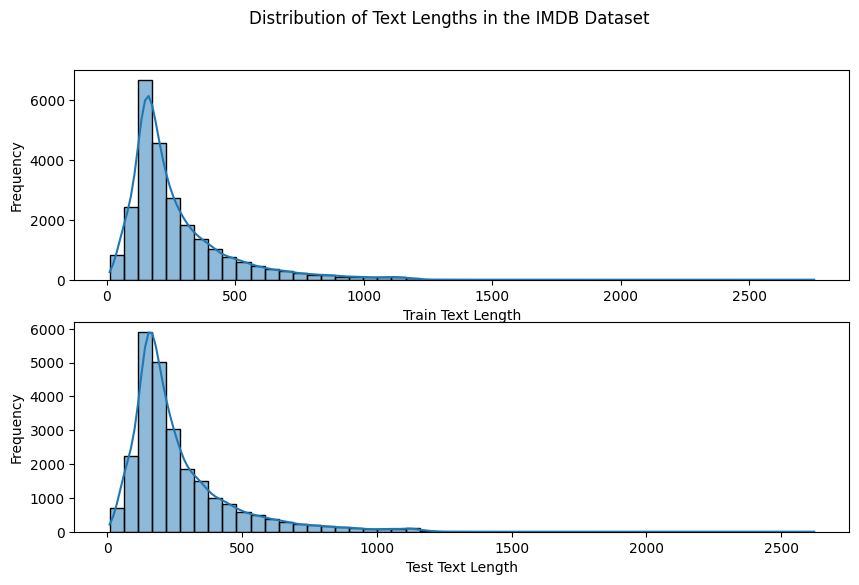

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate the length of each text in the dataset
def get_text_lengths(data_iter):
    lengths = []
    for _, text in tqdm(data_iter):
        tokenized_text = tokenizer(text)
        lengths.append(len(tokenized_text))
    return np.array(lengths)

# Load IMDB train dataset
train_iter, test_iter = IMDB(root='datasets', split=('train', 'test'))

# Get text lengths from the entire dataset
train_text_lengths = get_text_lengths(train_iter)
test_text_lengths = get_text_lengths(test_iter)
# Plot the distribution of text lengths

# Define bin edges using the range of both datasets
min_bin = min(train_text_lengths.min(), test_text_lengths.min())
max_bin = max(train_text_lengths.max(), test_text_lengths.max())
bins = np.linspace(min_bin, max_bin, 30)  # Adjust number of bins as needed

plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
sns.histplot(train_text_lengths, kde=True, bins=50)
plt.xlabel('Train Text Length')
plt.ylabel('Frequency')
plt.subplot(2,1,2)
sns.histplot(test_text_lengths, kde=True, bins=50)
plt.xlabel('Test Text Length')
plt.ylabel('Frequency')
plt.suptitle('Distribution of Text Lengths in the IMDB Dataset')
plt.show()

In [6]:
from torch.nn.utils.rnn import pad_sequence

# Define collate function for padding and batching
# setting a max_seq_len helps with estimating the max gpu memory usage
def collate_batch(batch, max_seq_len=1024):
    labels, texts = zip(*batch)
    # the labels start at 1 but predictions start at 0. To align them, we modify lables
    labels = torch.tensor(labels,dtype=torch.long)-1
    
    text_list = []
    for text in texts:
        # Truncate or pad to max_seq_len
        tokenized_text = text_pipeline(text)
        if len(tokenized_text) > max_seq_len:
            tokenized_text = tokenized_text[:max_seq_len]  # Truncate if longer than max_seq_len
        else:
            # Pad if shorter than max_seq_len
            tokenized_text = tokenized_text + [vocab["<pad>"]] * (max_seq_len - len(tokenized_text))
        
        text_list.append(torch.tensor(tokenized_text, dtype=torch.long))
    
    padded_texts = torch.stack(text_list)  # Stack the sequences into a tensor
    return padded_texts, labels

In [7]:
from torch.utils.data import Dataset
class IMDBDataset(Dataset):
    def __init__(self, data_iter):
        self.data_iter = list(data_iter)  # Converting the iterator to a list for easier access

    def __len__(self):
        return len(self.data_iter)

    def __getitem__(self, idx):
        label, text = self.data_iter[idx]
        return label, text

train_iter, test_iter = IMDB(root='datasets', split=('train', 'test'))
train_dataset = IMDBDataset(train_iter)
test_dataset = IMDBDataset(test_iter)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


# Train_loader and test_loader sanity check
# Initialize counter
label_counter = Counter()

# Iterate through batches in train_loader
for texts, labels in train_loader:
    label_counter.update(labels.tolist())
print("Label counts:", label_counter)

Label counts: Counter({1: 12500, 0: 12500})


In [8]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_encoder_layers, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_size, num_heads, embed_size * 2, dropout),
            num_encoder_layers
        )
        self.fc = nn.Linear(embed_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)  # Embedding layer
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, embedding_size)
        x = self.transformer(x)  # Apply transformer
        x = x.mean(dim=0)  # Pooling (take the mean of all tokens in the sequence)
        x = self.dropout(x)
        x = self.fc(x)  # Final classification layer
        return x

In [9]:
# Check for device compatibility, prioritizing CUDA, then MPS for MacBooks with Apple Silicon, and defaulting to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Initialize the model, 
embed_size = 32
num_heads = 4
num_encoder_layers = 2
num_classes = 2  # Positive or negative sentiment
model = TransformerModel(len(vocab), embed_size, num_heads, num_encoder_layers, num_classes)

# Initialize loss function, and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Using device: cuda


TransformerModel(
  (embedding): Embedding(100684, 32)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [10]:
def train_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    # total_batches = 0
    total_batches = len(train_loader)
    
    for texts, labels in tqdm(train_loader):
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(texts)
        
        # Compute loss and gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        correct = (preds == labels).sum().item()
        accuracy = correct / labels.size(0)
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy
    
    return epoch_loss / total_batches, epoch_accuracy / total_batches


def evaluate(model, test_loader, loss_fn):
    model.eval()
    epoch_loss = 0
    epoch_accuracy = 0
    total_batches = len(test_loader)
    
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts, labels = texts.to(device), labels.to(device)
            # Forward pass
            outputs = model(texts)
            
            # Compute loss
            loss = loss_fn(outputs, labels)
            
            # Calculate accuracy
            preds = torch.argmax(outputs, dim=1)
            correct = (preds == labels).sum().item()
            accuracy = correct / labels.size(0)
            
            epoch_loss += loss.item()
            epoch_accuracy += accuracy
    
    return epoch_loss / total_batches, epoch_accuracy / total_batches


In [11]:
num_epochs = 5
train_losses = np.zeros(num_epochs)
train_accuracies = np.zeros(num_epochs)

test_losses = np.zeros(num_epochs)
test_accuracies = np.zeros(num_epochs)

In [12]:

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Train for one epoch
    train_loss, train_accuracy = train_epoch(model, train_loader, loss_fn, optimizer)
    train_losses[epoch] = train_loss
    train_accuracies[epoch] = train_accuracy
    # Evaluate on the test set
    test_loss, test_accuracy = evaluate(model, test_loader, loss_fn)
    test_losses[epoch] = test_loss
    test_accuracies[epoch] = test_accuracy
    end_time = time.time()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Time: {end_time - start_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 77.67it/s]


Epoch [1/5] | Time: 64.46s
Train Loss: 0.5248 | Train Accuracy: 0.7138
Test Loss: 0.3812 | Test Accuracy: 0.8345


100%|████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 77.22it/s]


Epoch [2/5] | Time: 64.49s
Train Loss: 0.3173 | Train Accuracy: 0.8633
Test Loss: 0.3230 | Test Accuracy: 0.8599


100%|████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 76.88it/s]


Epoch [3/5] | Time: 64.23s
Train Loss: 0.2372 | Train Accuracy: 0.9047
Test Loss: 0.3181 | Test Accuracy: 0.8710


100%|████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 77.37it/s]


Epoch [4/5] | Time: 62.99s
Train Loss: 0.1842 | Train Accuracy: 0.9282
Test Loss: 0.3907 | Test Accuracy: 0.8529


100%|████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 76.28it/s]

Epoch [5/5] | Time: 64.45s
Train Loss: 0.1373 | Train Accuracy: 0.9496
Test Loss: 0.3605 | Test Accuracy: 0.8645


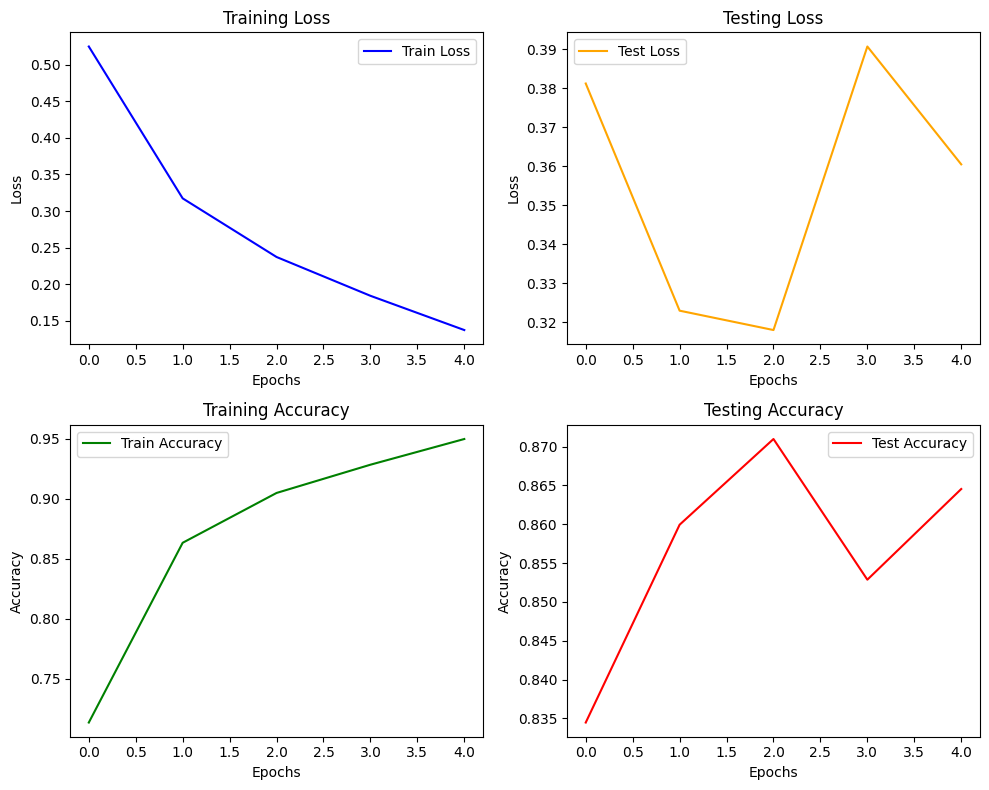

In [13]:
num_epochs = 5
epochs = list(range(0, num_epochs))

# Create 2x2 grid of subplots using plt.subplot
plt.figure(figsize=(10, 8))

# Training Loss
plt.subplot(2, 2, 1)  # (rows, columns, index)
plt.plot(epochs, train_losses, color='blue', label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Testing Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, test_losses, color='orange', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_accuracies, color='green', label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Testing Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, test_accuracies, color='red', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()